Library import

In [1]:
import pandas as pd
import numpy as np
#from cpi import inflate
import matplotlib.pyplot as plt

## 1. Files loading and preprocessing

The following cell organizes and preprocesses movie datasets from different time periods (1880–2010 and 2010–2024) using the MovieFrames class. It first imports the class, then loads the movie metadata for older and newer movies. File paths for additional datasets (such as sequels, books, comics, remakes, and collections) are dynamically generated for both time periods. The MovieFrames objects (movie_frames_old and movie_frames_new) are then created to structure and preprocess the data. The movie_frames_old object specifically standardizes column names for the older dataset using the old=True flag. These objects help manage movie data by categories and prepare it for further analysis.

In [2]:
from src.models.movies_frame import MovieFrames

movie_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
new_movie_df = pd.read_csv('data/random_sample/random_sample_metadata_2010_2024.csv')

keywords = ["sequels", "book", "comics", "remake"]
path_old = []
path_new = []

for keyword in keywords:
    path_old.append(f"data/{keyword}/{keyword}_with_wiki_id_1880_2010.csv")
    path_new.append(f"data/{keyword}/{keyword}_metadata_2010_2024.csv")

path_old.append("data/collections/sequels_and_original_with_wiki_id.csv")
path_new.append("data/collections/sequels_and_original_metadata_2010_2024.csv")

movie_frames_old = MovieFrames(movie_df, path_old, old=True)
movie_frames_new = MovieFrames(new_movie_df, path_new)


Then the following cell visualizes the size differences between datasets during the preprocessing steps using the display_data_cleaning_graph function. The function takes a MovieFrames object and calculates the number of movies at three stages:

- The original data loaded from TMDb.
- After matching the TMDb data with the Wikipedia data.
- After filtering out movies with mismatched release years.

These sizes are passed to the create_graph function, which generates a bar graph showing the changes in dataset sizes for five categories: sequel collections, sequels, books, comics, and remakes. The graph highlights how the preprocessing steps affect the number of movies in each category. 

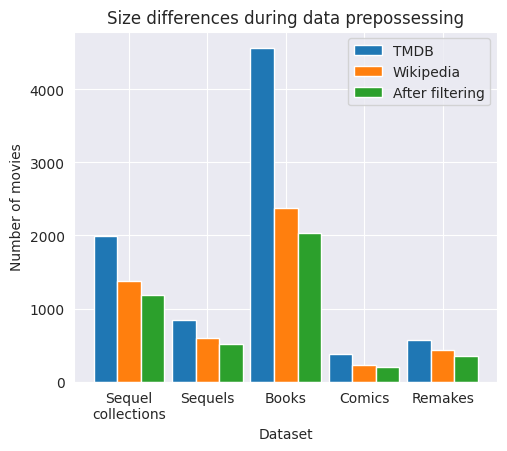

In [3]:
## Size differences
from src.models.movie_data_cleaner import display_data_cleaning_graph
fig = display_data_cleaning_graph(movie_frames_old)

plt.show()

### 3.1 How many sequels are there compared to movies 

Groups the movies by 5-year intervals, counts how many movies fall into each interval, and returns the string representation of the interval labels

Plot of number of movies per 5 year (left figure) VS. Plot of number of movies with sequels per 5 year (right figure)

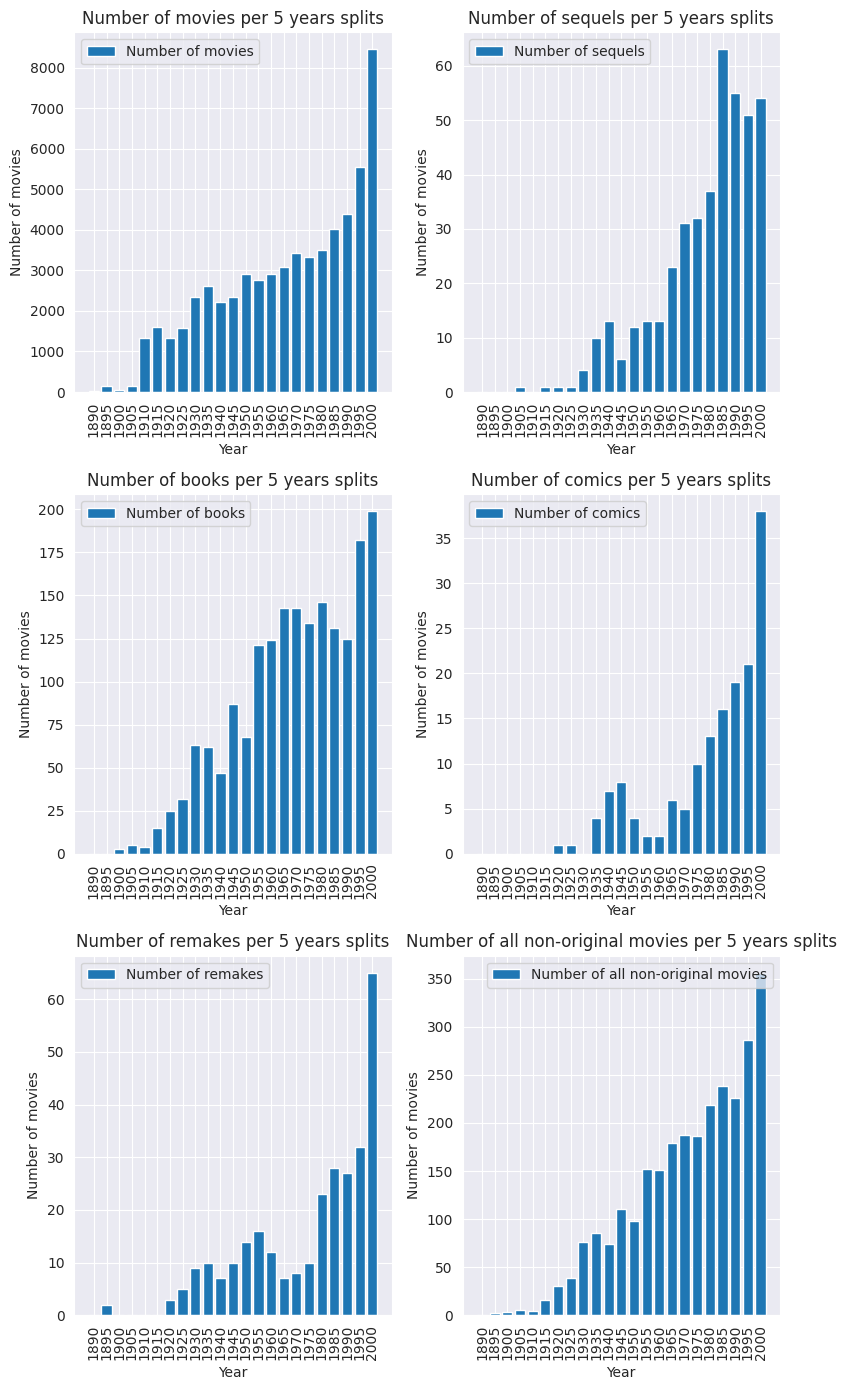

In [4]:
from src.models.movie_counter import get_movie_counter_figure

#Plot figure 1 (left):  number of movies per 5 years
fig = get_movie_counter_figure(movie_frames_old)

plt.tight_layout()
plt.show()

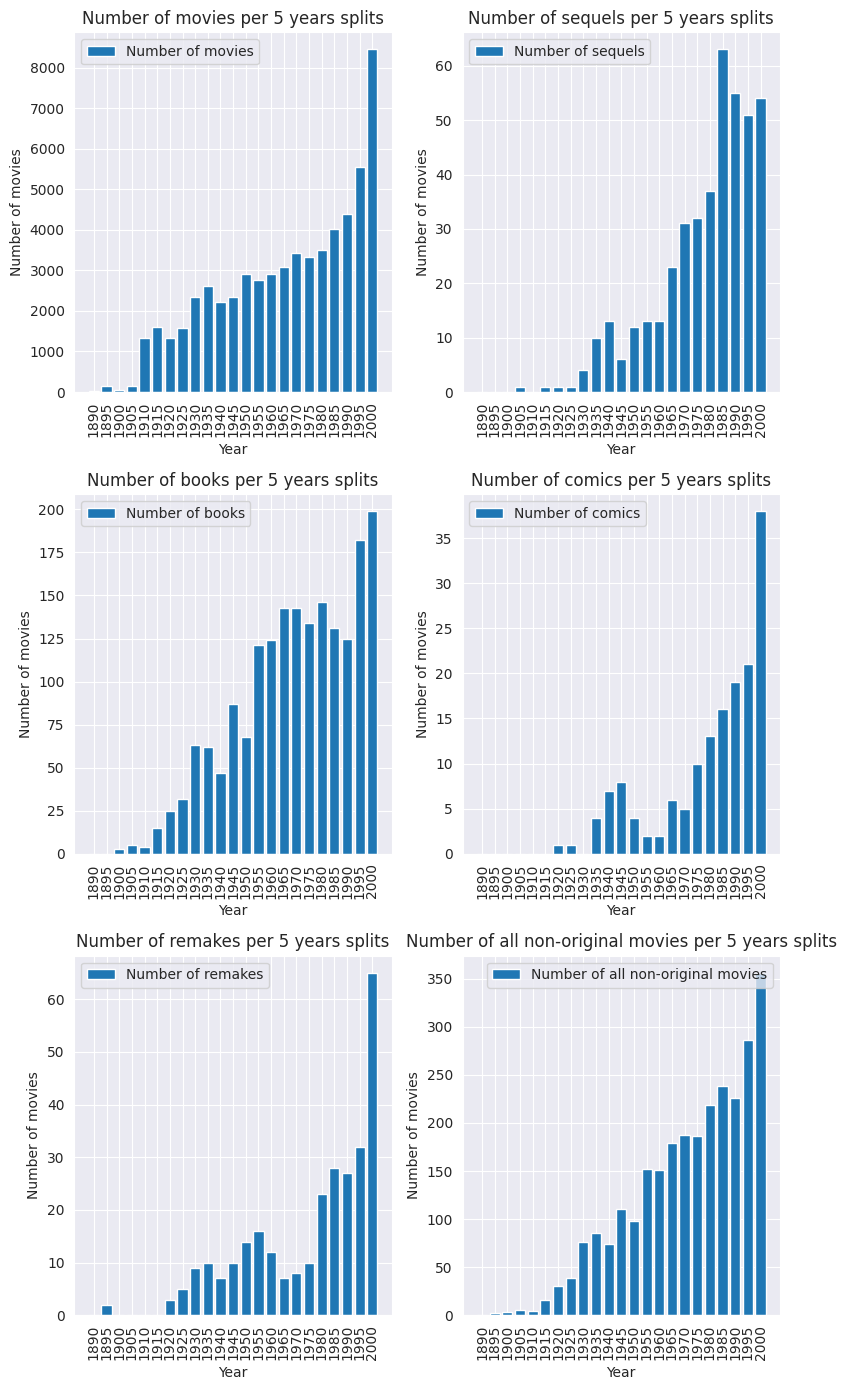

In [5]:
fig = get_movie_counter_figure(movie_frames_old)

plt.tight_layout()
plt.show()

$$
\text{Ratio} = \frac{\text{nb of movie with sequel per 5 year}}{\text{nb of movie per 5 year}}
$$

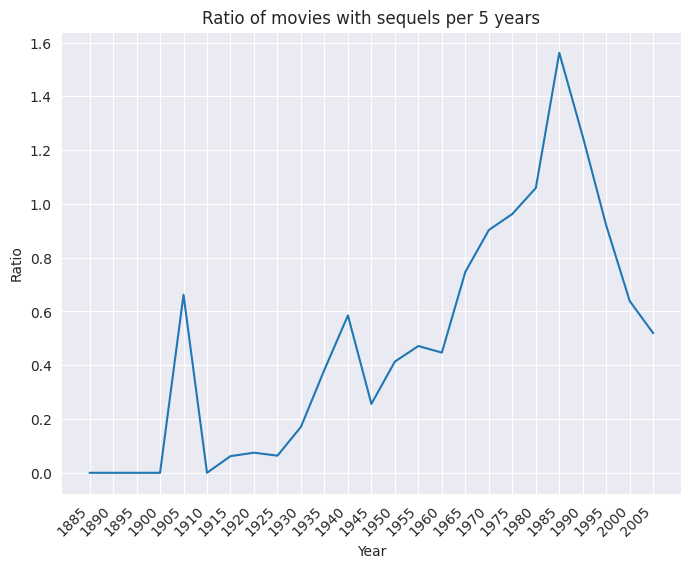

In [6]:

from src.models.movie_counter import get_ratio_movie_figure

fig = get_ratio_movie_figure(movie_frames_old)
plt.xticks(rotation=45, ha='right')
plt.show()

## 3.2 Box office revenue

#### 3.2.1 Box office revenue for movies with sequels compared to all movies

Creation of a function, using the Consumer Price Index (CPI), that calaculate the inflation adjustement for each movies based on their released year

Box office revenues inflation adjustement for other movies with sequels dataframe

Calculation and plot of total box office revenue per year

/home/yann/Documents/ada-2024-project-onceuponatimeindata/src/models/movies_frame.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.movie_df[column_name] = column_values


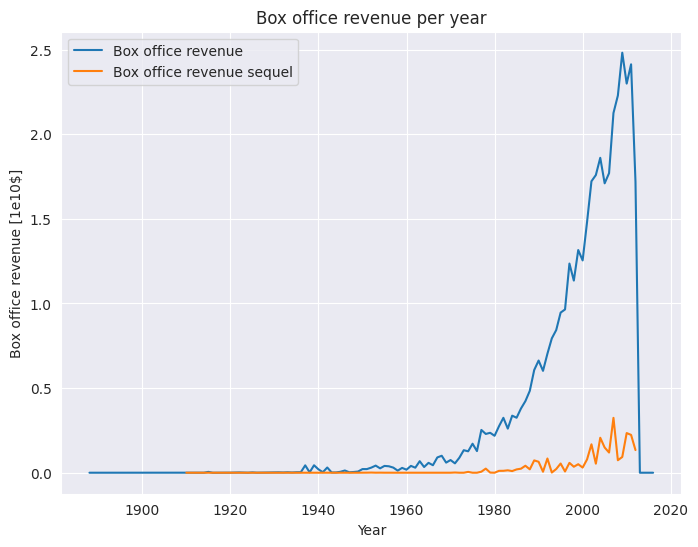

In [8]:
from models.box_office_revenue import get_box_office_absolute

# Plot figure 4: box office revenue per year
get_box_office_absolute(movie_frames_old)
plt.show()

Calculation and plots the percentage of box office revenue each year contributed by movies with sequels, relative to the total box office revenue for all movies that year

$$
\text{Box Office \%} = \frac{\text{Box office of movies with sequel per year}}{\text{Box office for all movies per year}} * 100
$$

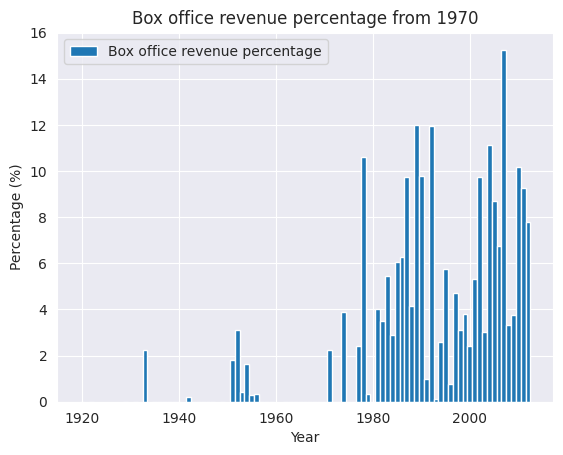

In [9]:
from src.models.box_office_revenue import get_box_office_ratio

fig = get_box_office_ratio(movie_frames_old)
plt.show()

Calculation and plot of the average inflation-adjusted box office revenue per year, both for all movies and for movies with sequels

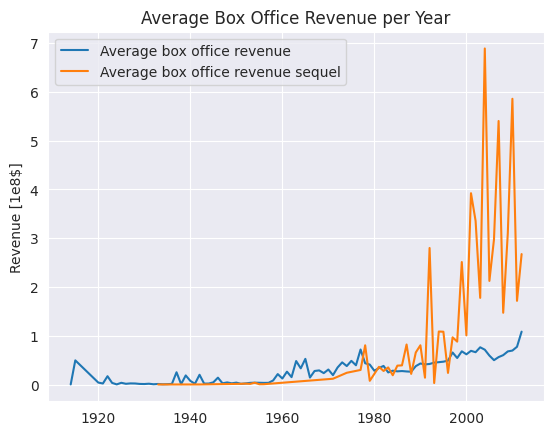

In [11]:
from src.models.box_office_revenue import get_average_box_office_revenue

get_average_box_office_revenue(movie_frames_old)
plt.show()

#### 3.2.2 Box office revenue for movies with sequel compared to the first movie of the collection

Creation of new DataFrame in order to store first movie and remain movies box office value

Plot the comparison between first and remaining movie of collections

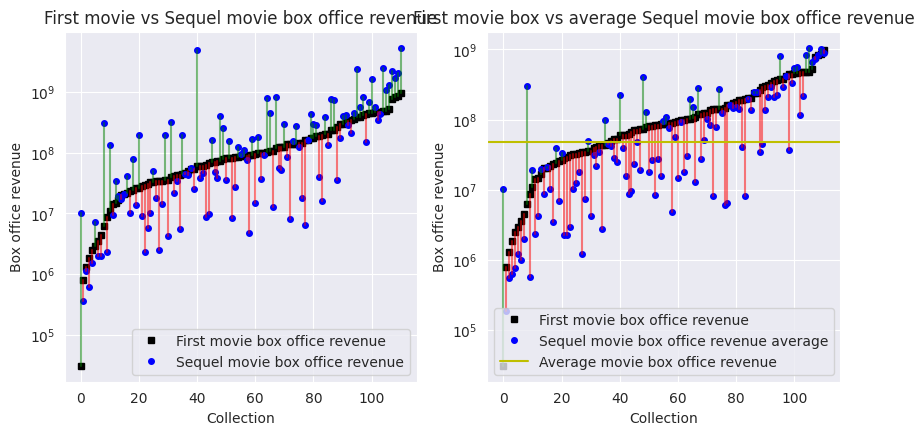

In [12]:
from src.models.box_office_revenue import compare_first_sequel

fig = compare_first_sequel(movie_frames_old)

plt.show()


These plots highlight where the first movie outperforms the sequel (red lines) and vice versa (green lines). The second plot also includes a yellow horizontal line showing the average box office revenue of all movies in the dataset.

The log scale on the y-axis is used to better visualize large differences in revenue, especially when there are very high values.

## 4. Number of movies in a collection

Plot of the comparison between the Budget and the Box office revenue for collection

In [ ]:
import seaborn as sns


plt.show()

In [ ]:
#Plot figure 10: number of movies in a collection

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot()
ax1.bar(collection_size['Movie name'], collection_size["count"], label="Number of movies in collection")
ax1.legend()
ax1.title.set_text("Number of movies in a collection")
ax1.set_xlabel("Number of sequels")
ax1.set_ylabel("Number of movies")

plt.show()

## Other line of enquiry:

- Highest grossing series
- By genre
- Find studios that do a lot of sequels
- Is there a correlation between the box office revenue of the first movie and the sequels
- Add more box office revenue data and get movie budget data
- ...